In [1]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    import zipfile

    with zipfile.ZipFile("/content/drive/MyDrive/Bigdata/Dataset.zip", "r") as zip_ref:
        zip_ref.extractall("./")
    datasetFolder = "/content/Dataset/Protocol/"
except:
    datasetFolder = "/content/Dataset/Protocol/"
    print("Using Local Machine")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import combinations

In [3]:
!pip install catboost

In [4]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [5]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin


In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv1D, LSTM, Dense, Flatten
from keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard,
)


In [7]:
physicalDevices = tf.config.list_physical_devices("GPU")
print(physicalDevices)
if len(physicalDevices) > 0:
    tf.config.experimental.set_memory_growth(physicalDevices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
ModelDir = "./Models/" + datetime.now().strftime("%Y%m%d-%H") + "/"


if not os.path.exists("./Models/"):
    os.mkdir("./Models/")


if not os.path.exists(ModelDir):

    os.mkdir(ModelDir)

In [9]:
ModelDir = "./Models/" + datetime.now().strftime("%Y%m%d-%H") + "/"


if not os.path.exists("./Models/"):
    os.mkdir("./Models/")


if not os.path.exists(ModelDir):

    os.mkdir(ModelDir)

In [10]:
%reload_ext tensorboard
logsDir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H")
tensorboardCBK = TensorBoard(log_dir=logsDir, histogram_freq=1)
earlyStoppingCBK = EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='min')
reduceLRPlateauCBK = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
callbacks = [earlyStoppingCBK,
             reduceLRPlateauCBK, tensorboardCBK]


In [11]:
def HeartRatePreprocess(dataFrame: pd.DataFrame):
    heartRateStartIndex = 0
    heartRates = dataFrame["heart rate (bpm)"].values
    heartRate = dataFrame["heart rate (bpm)"].median()
    for index in range(len(heartRates)):
        if heartRates[index] > 0:
            heartRate = heartRates[index]
            heartRateStartIndex = index
            break
    newHeartRates = []
    dataFrame = dataFrame[:][heartRateStartIndex:]
    for index in range(dataFrame.shape[0]):
        if heartRates[index] > 0:
            heartRate = heartRates[index]
            newHeartRates.append(heartRate)
        else:
            newHeartRates.append(heartRate)
    dataFrame["heart rate (bpm)"] = newHeartRates
    return dataFrame

In [12]:
def PreprocessDataset(dataFrame: pd.DataFrame, fillNAMethod: str = "mean"):
    dataFrame = dataFrame.drop(columns=["timestamp (s)"])
    columns = dataFrame.columns
    preprocessedDataFrame = []
    uniqueActivities = list(dataFrame["activityID"].unique())
    for uniqueActivity in uniqueActivities:
        subDataFrame = pd.DataFrame(
            dataFrame[dataFrame["activityID"] == uniqueActivity]
        )
        for column in columns:
            if column == "heart rate (bpm)":
                subDataFrame = HeartRatePreprocess(subDataFrame)
            else:
                if fillNAMethod == "mean":
                    columnMean = dataFrame[column].mean()
                    subDataFrame[column] = subDataFrame[column].fillna(columnMean)
                elif fillNAMethod == "median":
                    columnMedian = dataFrame[column].median()
                    subDataFrame[column] = subDataFrame[column].fillna(columnMedian)
        preprocessedDataFrame.append(subDataFrame)
    preprocessedDataFrame = pd.concat(preprocessedDataFrame, ignore_index=True)
    return preprocessedDataFrame

In [13]:
def LoadDataSet(folderPath: str):
    if os.path.isdir(folderPath) and folderPath[-1] != "/":
        print("enter a valid folderPath")
        return None
    dataFrames = []
    csvFiles = os.listdir(folderPath)
    for csvFile in csvFiles:
        print("Reading DataSet from", csvFile)
        dataFrame = pd.read_csv(
            folderPath + csvFile, index_col=None, header=0, dtype=float
        )
        dataFrame = PreprocessDataset(dataFrame)
        dataFrames.append(dataFrame)
    dataFrames = pd.concat(dataFrames, ignore_index=True)
    return dataFrames


dataFrame = LoadDataSet(datasetFolder)

Reading DataSet from subject105.csv
Reading DataSet from subject108.csv
Reading DataSet from subject101.csv
Reading DataSet from subject102.csv
Reading DataSet from subject106.csv
Reading DataSet from subject107.csv
Reading DataSet from subject104.csv


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Reading DataSet from subject109.csv
Reading DataSet from subject103.csv


In [14]:
def NormalizeData(dataFrame: pd.DataFrame):
    dataFrame = dataFrame.dropna()
    ssNormalizer = StandardScaler()
    normalizeColumns = dataFrame.columns.drop(
        ["activityID", "heart rate (bpm)"]
    )  # Exclude non-numeric columns
    dataFrame[normalizeColumns] = ssNormalizer.fit_transform(
        dataFrame[normalizeColumns]
    )
    return dataFrame, ssNormalizer


dataFrame, ssNormalizer = NormalizeData(dataFrame)

<ipython-input-14-48318c88219a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame[normalizeColumns] = ssNormalizer.fit_transform(


In [15]:
def DescribeDataFrame(dataFrame: pd.DataFrame):
    for column in dataFrame.columns:
        NaNCount = dataFrame.shape[0] - dataFrame[column].count()
        print("NaN Count in", column, ":", NaNCount)
        print(dataFrame[column].describe())
        print("-" * 30)


# DescribeDataFrame(dataFrame)

In [16]:
X = dataFrame.drop(columns=["activityID"])
y = dataFrame["activityID"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("Columns:", X_train.columns)

X_train Shape: (2297637, 40)
X_test Shape: (574410, 40)
Columns: Index(['heart rate (bpm)', 'hand_temperature (°C) ', 'hand_acc_16g_X',
       'hand_acc_16g_Y', 'hand_acc_16g_Z', 'hand_acc_6g_X', 'hand_acc_6g_Y',
       'hand_acc_6g_Z', 'hand_gyro_X', 'hand_gyro_Y', 'hand_gyro_Z',
       'hand_mag_X', 'hand_mag_Y', 'hand_mag_Z', 'chest_temperature (°C) ',
       'chest_acc_16g_X', 'chest_acc_16g_Y', 'chest_acc_16g_Z',
       'chest_acc_6g_X', 'chest_acc_6g_Y', 'chest_acc_6g_Z', 'chest_gyro_X',
       'chest_gyro_Y', 'chest_gyro_Z', 'chest_mag_X', 'chest_mag_Y',
       'chest_mag_Z', 'ankle_temperature (°C) ', 'ankle_acc_16g_X',
       'ankle_acc_16g_Y', 'ankle_acc_16g_Z', 'ankle_acc_6g_X',
       'ankle_acc_6g_Y', 'ankle_acc_6g_Z', 'ankle_gyro_X', 'ankle_gyro_Y',
       'ankle_gyro_Z', 'ankle_mag_X', 'ankle_mag_Y', 'ankle_mag_Z'],
      dtype='object')


In [17]:
def PCAReduction(X: pd.DataFrame, pca: PCA = None):
    if pca == None:
        pca = PCA()
        pca = pca.fit(X)
        X_pca = pca.transform(X)
        return X_pca, pca
    else:
        X_pca = pca.transform(X)
        return X_pca

In [18]:
if(os.path.exists(ModelDir + "pca.pkl")):
    pca = pickle.load(open(ModelDir + "pca.pkl", "rb"))
    X_train = PCAReduction(X_train, pca=pca)
    X_test = PCAReduction(X_test, pca=pca)
else:
    X_train, pca = PCAReduction(X_train)
    X_test = PCAReduction(X_test, pca=pca)

print("X_train_pca Shape:", X_train.shape)
print("X_test_pca Shape:", X_test.shape)

X_train_pca Shape: (2297637, 40)
X_test_pca Shape: (574410, 40)


In [19]:
# plt.figure()
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel("Number of Components")
# plt.ylabel("Variance (%)")
# plt.title("Explained Variance")
# plt.savefig()

In [20]:
def EncodingLabels(y: np.ndarray, labelEncoder: LabelEncoder = None):
    if labelEncoder == None:
        labelEncoder = LabelEncoder()
        labelEncoder = labelEncoder.fit(y)
        y_encoded = labelEncoder.transform(y)
        return y_encoded, labelEncoder
    else:
        y_encoded = labelEncoder.transform(y)
        return y_encoded

In [21]:
y_train, labelEncoder = EncodingLabels(y_train)
y_test = EncodingLabels(y_test, labelEncoder=labelEncoder)

print("y_train_encoded Shape:", y_train.shape)
print("y_test_encoded Shape:", y_test.shape)

y_train_encoded Shape: (2297637,)
y_test_encoded Shape: (574410,)


In [22]:
def RFEElimination(
    x: pd.DataFrame, y: pd.DataFrame = None, n_features: int = None, rfe: RFE = None
):
    if rfe == None:
        baseEstimator = RandomForestClassifier(n_jobs=-1)

        # baseEstimator = XGBClassifier(tree_method="hist", device="cuda", verbosity=2)
        rfe = RFE(baseEstimator, n_features_to_select=n_features, step=1, verbose=1)
        rfe = rfe.fit(x, y)
        X_rfe = rfe.transform(x)
        return X_rfe, rfe
    else:
        X_rfe = rfe.transform(x)
        return X_rfe

In [23]:
if(os.path.exists(ModelDir + "RFE.pkl")):
    pca_rfe = pickle.load(open(ModelDir + "RFE.pkl", "rb"))
    X_train = RFEElimination(X_train, rfe=pca_rfe)
    X_test = RFEElimination(X_test, rfe=pca_rfe)
else:
    X_train, pca_rfe = RFEElimination(X_train, y_train)
    X_test = RFEElimination(X_test, rfe=pca_rfe)

print("X_train_pca_rfe Shape:", X_train.shape)
print("X_test_pca_rfe Shape:", X_test.shape)


Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
X_train_pca_rfe Shape: (2297637, 20)
X_test_pca_rfe Shape: (574410, 20)


In [24]:
with open(ModelDir + "PCA.pkl", "wb") as pickle_file:
    pickle.dump(pca, pickle_file)

In [25]:
with open(ModelDir + "RFE-.pkl", "wb") as RFE_file:
    pickle.dump(pca_rfe, RFE_file)

In [26]:
def BuildXGBClassifier(
    parameters: dict = {"tree_method": "hist", "device": "cuda", "verbosity": 2}
):
    XGBModel = XGBClassifier(**parameters)
    return XGBModel

In [27]:
def BuildLGBClassifier(parameters: dict = {"device": "gpu", "verbosity": 1}):
    LGBModel = LGBMClassifier(**parameters)
    return LGBModel

In [28]:
def BuildCBClassifier(
    parameters: dict = {
        "task_type": "GPU",
        "devices": "0:1",
        "verbose": 1,
        "iterations": 1000,
    }
):
    CBModel = CatBoostClassifier(**parameters)
    return CBModel

In [50]:
class CNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        inputShape,
        numClasses,
        epochs,
        batchSize,
        lossFunction,
        optimizer,
        metrics,
        verbose,
    ):
        self.verbose = verbose
        self.lossFunction = lossFunction
        self.optimizer = optimizer
        self.metrics = metrics
        self.inputShape = inputShape
        self.numClasses = numClasses
        self.epochs = epochs
        self.batchSize = batchSize
        self.classes_ = np.arange(self.numClasses)
        self.model = self.BuildCNNModel()

    def fit(self, X, y):
        X = X.reshape((X.shape[0], self.inputShape[0], self.inputShape[1]))
        y = to_categorical(y, self.numClasses)

        self.model.fit(
            X, y, epochs=self.epochs, batch_size=self.batchSize, verbose=self.verbose
        )
        return self

    def predict(self, X):
        X = X.reshape((X.shape[0], self.inputShape[0], self.inputShape[1]))

        predictions = self.model.predict(X)
        return (predictions > 0.5).astype("int32")

    def predict_proba(self, X):
        return self.model.predict(X)

    def BuildCNNModel(self):
        model = Sequential()
        model.add(
            Conv1D(
                filters=64,
                kernel_size=3,
                activation="relu",
                input_shape=self.inputShape,
            )
        )
        model.add(Flatten())
        model.add(Dense(50, activation="relu"))
        model.add(Dense(self.numClasses, activation="softmax"))
        model.compile(
            loss=self.lossFunction,
            optimizer=self.optimizer,
            metrics=self.metrics,
        )
        return model

In [51]:
class LSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        inputShape,
        numClasses,
        epochs,
        batchSize,
        lossFunction,
        optimizer,
        metrics,
        verbose,
    ):
        self.verbose = verbose
        self.lossFunction = lossFunction
        self.optimizer = optimizer
        self.metrics = metrics
        self.inputShape = inputShape
        self.numClasses = numClasses
        self.epochs = epochs
        self.batchSize = batchSize
        self.classes_ = np.arange(self.numClasses)
        self.model = self.BuildLSTMModel()

    def fit(self, X, y):
        X = X.reshape((X.shape[0], self.inputShape[0], self.inputShape[1]))
        y = to_categorical(y, self.numClasses)
        self.model.fit(
            X, y, epochs=self.epochs, batch_size=self.batchSize, verbose=self.verbose
        )
        return self

    def predict(self, X):
        X = X.reshape((X.shape[0], self.inputShape[0], self.inputShape[1]))

        predictions = self.model.predict(X)
        return (predictions > 0.5).astype("int32")

    def predict_proba(self, X):
        return self.model.predict(X)

    def BuildLSTMModel(self):
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=self.inputShape))
        model.add(LSTM(50))
        model.add(Dense(50, activation="relu"))
        model.add(Dense(self.numClasses, activation="softmax"))
        model.compile(
            loss=self.lossFunction,
            optimizer=self.optimizer,
            metrics=self.metrics,
        )
        return model

In [31]:
def CreateEnsembleCombinations(MLModelsNames: list, minimumModels: int):
    EnsembleCombinations = []
    for length in range(minimumModels, len(MLModelsNames) + 1):
        for combo in combinations(MLModelsNames, length):
            EnsembleCombinations.append(list(combo))

    return EnsembleCombinations

In [52]:
lossFunction = "categorical_crossentropy"
optimizer = "adam"
metrics = ["accuracy"]
MLModelsNames = ["XGBModel", "CBModel", "CNNModel", "LSTMModel"]

In [53]:
inputShape = (X_train.shape[1], 1)
classLabels = np.unique(y_train)
numClasses = len(classLabels)
print("inputShape:", inputShape)
print("classLabels:", classLabels)
print("numClasses:", numClasses)

inputShape: (20, 1)
classLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
numClasses: 13


In [54]:
XGBModel = BuildXGBClassifier()
LGBModel = BuildLGBClassifier()
CBModel = BuildCBClassifier()
CNNModel = CNNClassifier(
    inputShape=inputShape,
    numClasses=numClasses,
    epochs=1,
    batchSize=32,
    lossFunction=lossFunction,
    optimizer=optimizer,
    metrics=metrics,
    verbose=1,
)
LSTMModel = LSTMClassifier(
    inputShape=inputShape,
    numClasses=numClasses,
    epochs=1,
    batchSize=32,
    lossFunction=lossFunction,
    optimizer=optimizer,
    metrics=metrics,
    verbose=1,
)
MLModels = {
    "XGBModel": XGBModel,
    # "LGBModel": LGBModel,
    "CBModel": CBModel,
    "CNNModel": CBModel,
    "LSTMModel": LSTMModel,
}

In [55]:
EnsembleCombinations = CreateEnsembleCombinations(MLModelsNames, 2)
EnsembleCombinations.reverse()

Streaming output truncated to the last 5000 lines.
15:	learn: 0.7754624	total: 442ms	remaining: 27.2s
16:	learn: 0.7636924	total: 467ms	remaining: 27s
17:	learn: 0.7481265	total: 495ms	remaining: 27s
18:	learn: 0.7354653	total: 520ms	remaining: 26.8s
19:	learn: 0.7183287	total: 545ms	remaining: 26.7s
20:	learn: 0.7041179	total: 572ms	remaining: 26.7s
21:	learn: 0.6897583	total: 598ms	remaining: 26.6s
22:	learn: 0.6740950	total: 625ms	remaining: 26.5s
23:	learn: 0.6597280	total: 651ms	remaining: 26.5s
24:	learn: 0.6498303	total: 675ms	remaining: 26.3s
25:	learn: 0.6380289	total: 702ms	remaining: 26.3s
26:	learn: 0.6294584	total: 726ms	remaining: 26.2s
27:	learn: 0.6213988	total: 751ms	remaining: 26.1s
28:	learn: 0.6153178	total: 776ms	remaining: 26s
29:	learn: 0.6059305	total: 803ms	remaining: 26s
30:	learn: 0.5952816	total: 830ms	remaining: 25.9s
31:	learn: 0.5849085	total: 856ms	remaining: 25.9s
32:	learn: 0.5807788	total: 877ms	remaining: 25.7s
33:	learn: 0.5730752	total: 905ms	remai

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17951/17951 [==============================] - 50s 3ms/step
Model Metrics:
Accuracy: 0.9782803224177852
Precision: 0.980091905520138
Recall: 0.9749498329420637
F1 Score: 0.9774851643721872
Plotting Confusion Matrix


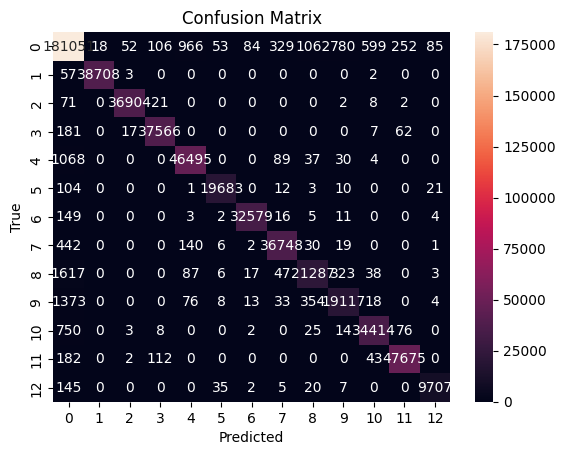

In [56]:
for EnsembleCombination in EnsembleCombinations:
    estimators = []
    for modelName in EnsembleCombination:
        estimators.append((modelName, MLModels[modelName]))
    print("EnsembleClassifer combination:", EnsembleCombination)
    EnsembleClassifer = StackingClassifier(
        estimators=estimators, verbose=1, final_estimator=LogisticRegression(n_jobs=1)
    )
    EnsembleClassifer.fit(X_train, y_train)

    y_pred = EnsembleClassifer.predict(X_test)
    y_pred_proba = EnsembleClassifer.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print("Model Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    pklFileName = "-".join(EnsembleCombination)
    with open(ModelDir + pklFileName + ".pkl", "wb") as pklFile:
        pickle.dump(EnsembleClassifer, pklFile)

    print("Plotting Confusion Matrix")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    break